## Approaches worth mentioning that were tried but finally not used

The following Sections contain descriptions and the code of the approaches that we tried but decided not to use in the final clean notebook due to MAE performance.

### Outlier Handling


**Our approach:**
- We treat outliers as a **data quality + robustness problem**, not as a reason to delete rare cars.
- We keep the process **leakage-safe** by implementing outlier handling as an sklearn transformer inside the pipeline (thresholds learned on training folds only).
- We explicitly separate:
  - **logical inconsistencies** found in the EDA (handled deterministically in `CarDataCleaner`),
  - vs. **statistical extremes** (handled in `OutlierHandler`).
- **Identification** of outliers
  - **Voting of robust univariate detectors:**
    - **Tukey IQR fences (1.5×IQR)**
      - Flags a value if it lies outside:
        - `Q1 − 1.5·IQR` or `Q3 + 1.5·IQR`
      - Strength: non-parametric, robust, widely used baseline (boxplot rule).
    - **Modified Z-score using Median Absolute Deviation (MAD)**
      - Robust alternative to z-scores:
        - uses the **median** instead of mean
        - uses **MAD** instead of standard deviation
      - Typical threshold: `|modified_z| > 3.5`
      - Strength: less sensitive to extreme tails than mean/std-based z-scores.
    - **Voting rule** (for robustness):
      - A value is treated as an outlier only if both methods agree (`min_votes=2`).
      - This reduces false positives compared to using only IQR fences on skewed distributions.
- **Treatment of Outliers:**
  - **Winsorization** (clip extreme values):
    - We keep every car in the dataset (no row deletion).
    - We reduce the influence of extreme values while still preserving information and rank order in the feature.
    - We **clip** flagged values to conservative bounds (`action="clip"`):
      - For each numeric feature we compute robust lower/upper bounds (from IQR and MAD-based thresholds).
      - Values outside those bounds are replaced by the nearest bound (winsorization).
- **Benefits** of this approach:
  - Keeps rare cars (no row deletion).
  - Avoids replacing informative extremes with typical medians (which can hurt tree models).
  - Stabilizes downstream steps (imputation, feature engineering, scaling) without collapsing signal into missingness.
- **Model-family sensitivity:** 
  - winsorization is especially helpful for linear/SVR models (reduces leverage points) and remains safe for trees
  - we keep one unified default pipeline for comparability.

<u>Place in the pipe</u>: 
- Before imputation to use original distribution for identifying the outliers (otherwise we would inflate the distributions with the imputed values)
- Then in imputation, fill the original gaps based on a distribution that does not includes the massive outliers (skewing the mean/median)    
  -> kill the outliers first (set to NaN) so the imputation for everyone becomes cleaner

Further tried but unused techniques:
- **Drop outside 1.5*IQR:** We decided against the classical “drop rows outside 1.5×IQR” because of:
    - The classical 1.5×IQR boxplot rule (Tukey fences) is a strong baseline, but real-world car variables (especially mileage) are often skewed / heavy-tailed, which can over-flag valid high values.
    - Dropping rows removes rare but valid cars (e.g., very high mileage vehicles), which is undesirable for production.
- **NaN into Imputation:** Set outliers found by Voting of robust univariate detectors to NaN and impute later with (`action="nan"`), but this significantly hurt the best averaged CV MAE

In [ ]:
# The way it was called in the pipeline:
preprocessor_pipe = Pipeline([
    ("clean", CarDataCleaner(handle_electric="other", set_carid_index=False, use_fuzzy=True)),
    # [Unused Outlier Handling]
    ("outliers", OutlierHandler(
        cols=[c for c in orig_numeric_features if c != "mileage"],      # only original numeric features here, no mileage because of log transform later
        methods=("iqr", "mod_z"),                                       # robust voting
        min_votes=2,                                                    # outlier if both methods agree
        iqr_k=1.5,
        z_thresh=3.5,
        action="clip",                                                   
        verbose=False,
    )),
    # [Unused Group Imputer Handling]
    ("fe", CarFeatureEngineer(ref_year=2020)),
    ("ct", (enc_transf_scale)),
    ("fs", (fs_pipe)),
])


OutlierHandler report
Action: clip (we never drop rows)
Total cells flagged: 22652


column  cells_flagged
0             tax          19928
1            year           1663
2      engineSize            619
3             mpg            442
4  previousOwners              0

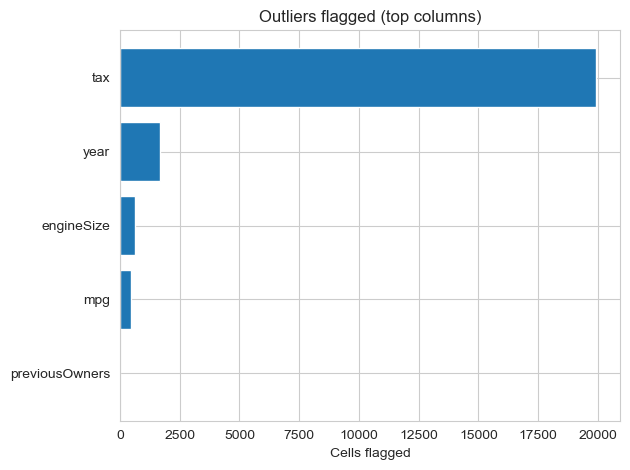


--- AFTER OUTLIER HANDLING ---
Shape: (75973, 12)
Type: <class 'pandas.core.frame.DataFrame'>

First 5 rows:


carID   brand     model    year transmission  mileage fuelType    tax  \
0  69512      VW      golf  2016.0    Semi-Auto  28421.0   Petrol    NaN   
1  53000  Toyota     yaris  2019.0       Manual   4589.0   Petrol  145.0   
2   6366    Audi        q2  2019.0    Semi-Auto   3624.0   Petrol  145.0   
3  29021    Ford    fiesta  2018.0       Manual   9102.0   Petrol  145.0   
4  10062     BMW  2 series  2019.0       Manual   1000.0   Petrol  145.0   

    mpg  engineSize  previousOwners  hasDamage  
0  22.0         2.0             4.0        0.0  
1  47.0         1.5             1.0        0.0  
2  40.0         1.5             4.0        0.0  
3  65.0         1.0             NaN        0.0  
4  42.0         1.5             3.0        0.0

count unique     top   freq          mean           std  \
carID           75973.0    NaN     NaN    NaN       37986.0  21931.660338   
brand             75933      9    Ford  16386           NaN           NaN   
model             74431    183   focus   6915           NaN           NaN   
year            74124.0    NaN     NaN    NaN   2017.133258      1.898376   
transmission      73692      4  Manual  41615           NaN           NaN   
mileage         74141.0    NaN     NaN    NaN  23352.794392   21620.62257   
fuelType          74462      4  Petrol  41181           NaN           NaN   
tax             67691.0    NaN     NaN    NaN    140.099034     14.575859   
mpg             67777.0    NaN     NaN    NaN     54.099621      11.75917   
engineSize      73939.0    NaN     NaN    NaN      1.662149      0.523728   
previousOwners  74052.0    NaN     NaN    NaN      2.015057      1.440985   
hasDamage       74425.0    NaN     NaN    NaN           0.0           0.0   

                        min      25%      50%      75%         max  
carID                   0.0  18993.0  37986.0  56979.0     75972.0  
brand                   NaN      NaN      NaN      NaN         NaN  
model                   NaN      NaN      NaN      NaN         NaN  
year            2011.810971   2016.0   2017.0   2019.0      2020.0  
transmission            NaN      NaN      NaN      NaN         NaN  
mileage                 1.0   7556.0  17416.0  32510.0    323000.0  
fuelType                NaN      NaN      NaN      NaN         NaN  
tax              119.054855    125.0    145.0    145.0  170.945145  
mpg                    22.0     46.0     54.0     62.0        86.0  
engineSize              0.6      1.2      1.6      2.0         3.2  
previousOwners          0.0      1.0      2.0      3.0         6.0  
hasDamage               0.0      0.0      0.0      0.0         0.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   brand           75933 non-null  object 
 2   model           74431 non-null  object 
 3   year            74124 non-null  float64
 4   transmission    73692 non-null  object 
 5   mileage         74141 non-null  float64
 6   fuelType        74462 non-null  object 
 7   tax             67691 non-null  float64
 8   mpg             67777 non-null  float64
 9   engineSize      73939 non-null  float64
 10  previousOwners  74052 non-null  float64
 11  hasDamage       74425 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 7.0+ MB


None


Generating data profiling report...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 27.01it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
debug_preprocessor_pipe = Pipeline([
    ("clean", CarDataCleaner(handle_electric="other", set_carid_index=False, use_fuzzy=True)),
    # [Unused Outlier Handling]
    ('debug_after_outliers', DebugTransformer('AFTER OUTLIER HANDLING', show_data=show_data, y_data_profiling=y_data_profiling)),
])

# We call fit_tranform here on the entire training data to just visualize the result. The insights from here are not used for anything else in model decisions so it's not leakage
X_result = debug_preprocessor_pipe.fit_transform(X_train, y_train)

### Group Imputer

**Our approach:**
- We use a custom **hierarchical GroupImputer** to impute missing values in a way that matches the structure of the car market.
- Instead of imputing from the full dataset only (global statistics), we first try to impute from **the most similar cars**:
  - same `brand` and same `model` (closest peer group),
  - otherwise same `brand`,
  - otherwise the global dataset.
- This is more realistic than a single global median because many variables (e.g., `engineSize`, `mpg`, `tax`) are strongly segment-dependent.

**Leakage safety:**
- The `GroupImputer` is implemented as an sklearn transformer in the pipeline.
- Therefore, during cross-validation it learns all medians/modes **only on the training fold** in `fit()` and applies them to the validation fold in `transform()` (no leakage).

---

##### Place in the pipe

> `CarDataCleaner` → `OutlierHandler` → `GroupImputer` → `CarFeatureEngineer` → `encoding/scaling` → `FS` → `model`

**Justification:**
- Imputation must happen on **original features** first, because feature engineering creates ratios/interactions (e.g., `miles_per_year`, `engine_per_mpg`) that would otherwise explode or become undefined when inputs are missing.
- We impute **before** feature engineering to ensure engineered features are computed on complete, consistent base variables.

---

##### Why medians/modes:

- **Median** is robust to skewed distributions (common in `mileage`, `tax`) and less sensitive to extreme values than the mean.
- **Mode** is the natural robust default for categorical variables.

---

##### Implementation notes:

- `group_cols` are used only to define groups; they themselves are **not imputed**.
- The transformer is deterministic: ties in categorical mode are handled consistently (pandas `.mode()` → first entry).
---


In [ ]:
class GroupImputer(BaseEstimator, TransformerMixin):
    """
    Hierarchical imputer for numeric + categorical features.

    Idea:
    ----
    We have to  compute the median value for the train dataset and fill the missing values in train, validation and test set with the median from the train dataset.
    For each row with a missing value, fill it using statistics from "similar" rows first, and only fall back to global statistics if needed.

    Hierarchy for numeric columns (num_cols):
        1) median per (group_cols[0], group_cols[1])    > we use brand, model
        2) median per group_cols[0]                     > we use brand
        3) global median across all rows

    Hierarchy for categorical columns (cat_cols):
        1) mode per (group_cols[0], group_cols[1])      > we use brand, model
        2) mode per group_cols[0]                       > we use brand
        3) global mode across all rows

    Notes:
    -----
    - `group_cols` are used only to define groups; they themselves are not imputed.
    - `num_cols` and `cat_cols` can be given explicitly (lists of column names). If None, they are inferred from the dtypes in `fit`.
    """

    def __init__(self, group_cols=("brand", "model"), num_cols=None, cat_cols=None, fallback="__MISSING__", verbose=False, verbose_top_n=10):
        self.group_cols = group_cols
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.fallback = fallback
        self.verbose = verbose
        self.verbose_top_n = verbose_top_n

    # helpers
    def _mode(self, s: pd.Series):
        """
        Deterministic mode helper.

        - Compute the most frequent non-null value.
        - If multiple values tie, Series.mode() returns them in order, we take .iloc[0].
        - If there is no valid mode (all NaN), return fallback token.
        """
        m = s.mode(dropna=True)
        if not m.empty:
            return m.iloc[0]
        return self.fallback

    def _get_group_series(self, df: pd.DataFrame, col_name: str) -> pd.Series:
        """
        Get the FIRST physical column with the given label from df.

        Reason
        ------
        - In some workflows, df.columns can contain duplicate labels
          (e.g. "brand" appearing twice after some operations).
        - df["brand"] would then raise "Grouper for 'brand' not 1-dimensional".
        - By using np.where(df.columns == col_name)[0] we get *positions* and
          explicitly pick the first one.

        Raises
        ------
        ValueError if no column with that name exists.
        """
        matches = np.where(df.columns == col_name)[0]
        if len(matches) == 0:
            raise ValueError(f"GroupImputer: grouping column '{col_name}' not found in data.")
        return df.iloc[:, matches[0]]

    def fit(self, X, y=None):
        """
        Learn the group-level and global statistics from the training data.

        Steps
        -----
        1) Convert X to DataFrame and remember the original column order.
        2) Resolve which columns are numeric/categorical to impute.
        3) Build group keys (g0, g1) from group_cols (e.g. brand, model).
        4) For numeric columns:
            - compute global medians
            - medians per g0 (e.g. per brand)
            - medians per (g0, g1) (e.g. per brand+model)
        5) For categorical columns:
            - global modes
            - modes per g0
            - modes per (g0, g1)
        """

        df = pd.DataFrame(X).copy()
        self.feature_names_in_ = df.columns.to_list()

        # group_cols must contain at least one column name
        if self.group_cols is None or len(self.group_cols) == 0:
            raise ValueError("GroupImputer: at least one group column must be specified.")

        self.group_cols_ = list(self.group_cols)

        # Determine numeric columns to impute (internal num_cols_)
        if self.num_cols is None:
            # If not specified: all numeric columns except the group columns
            num_cols_all = df.select_dtypes(include="number").columns.tolist()
            self.num_cols_ = [c for c in num_cols_all if c not in self.group_cols_]
        else:
            # If specified: keep only those that exist in df
            self.num_cols_ = [c for c in self.num_cols if c in df.columns]

        # Determine categorical columns to impute (internal cat_cols_)
        if self.cat_cols is None:
            # If not specified: all non-group, non-numeric columns
            self.cat_cols_ = [c for c in df.columns if c not in self.group_cols_ + self.num_cols_]
        else:
            # If specified: keep only those that exist in df
            self.cat_cols_ = [c for c in self.cat_cols if c in df.columns]

        # Build group key series based on the current df
        # g0 = first grouping column (e.g. brand)
        g0 = self._get_group_series(df, self.group_cols_[0])

        # g1 = second grouping column (e.g. model), optional
        g1 = None
        if len(self.group_cols_) > 1:
            g1 = self._get_group_series(df, self.group_cols_[1])

        # numeric statistics
        if self.num_cols_:
            # Extract the numeric columns to impute
            num_df = df[self.num_cols_].copy()

            # 3) Global median per numeric column (fallback for any group with no stats)
            self.num_global_ = num_df.median(numeric_only=True)

            # 2) Median per first-level group (g0, e.g. brand)
            num_first = num_df.copy()
            num_first["_g0"] = g0.values  # temporary group key column
            self.num_first_ = num_first.groupby("_g0", dropna=True).median(numeric_only=True)

            # 1) Median per pair (g0, g1), e.g. (brand, model)
            if g1 is not None:
                num_pair = num_df.copy()
                num_pair["_g0"] = g0.values
                num_pair["_g1"] = g1.values
                self.num_pair_ = num_pair.groupby(["_g0", "_g1"], dropna=True).median(numeric_only=True)
            else:
                self.num_pair_ = pd.DataFrame()
        else:
            self.num_global_ = pd.Series(dtype="float64")
            self.num_first_ = pd.DataFrame()
            self.num_pair_ = pd.DataFrame()

        # categorical statistics
        if self.cat_cols_:
            cat_df = df[self.cat_cols_].copy()

            # 3) Global mode per categorical column
            self.cat_global_ = pd.Series({c: self._mode(cat_df[c]) for c in self.cat_cols_}, dtype="object")

            # 2) Mode per first-level group (g0)
            cat_first = cat_df.copy()
            cat_first["_g0"] = g0.values
            self.cat_first_ = cat_first.groupby("_g0", dropna=True).agg(lambda s: self._mode(s))

            # 1) Mode per pair (g0, g1)
            if g1 is not None:
                cat_pair = cat_df.copy()
                cat_pair["_g0"] = g0.values
                cat_pair["_g1"] = g1.values
                self.cat_pair_ = cat_pair.groupby(["_g0", "_g1"], dropna=True).agg(lambda s: self._mode(s))
            else:
                self.cat_pair_ = pd.DataFrame()
        else:
            self.cat_global_ = pd.Series(dtype="object")
            self.cat_first_ = pd.DataFrame()
            self.cat_pair_ = pd.DataFrame()

        return self

    def transform(self, X):
        """
        Apply hierarchical imputation to new data.
            1) Convert input to DataFrame and align columns to what fit() saw.
            2) Rebuild group keys g0, g1 from the current data.
            3) For each numeric column with missing values:
                - try pair-level median (g0, g1)
                - then brand-level median (g0)
                - then global median
            4) Same for categorical columns with modes.
        """
        df = pd.DataFrame(X).copy()
        df = df.reindex(columns=self.feature_names_in_)

        g0 = self._get_group_series(df, self.group_cols_[0])
        g1 = None
        if len(self.group_cols_) > 1:
            g1 = self._get_group_series(df, self.group_cols_[1])

        # NEW: audit counters
        report = {"num_pair": 0, "num_brand": 0, "num_global": 0, "cat_pair": 0, "cat_brand": 0, "cat_global": 0}
        per_col = Counter()

        # numeric imputation
        if hasattr(self, "num_cols_") and self.num_cols_:
            df[self.num_cols_] = df[self.num_cols_].astype("float64")
            to_impute_num = [c for c in self.num_cols_ if df[c].isna().any()]

            if to_impute_num:
                # 1) pair-level imputation: per (g0, g1)
                if g1 is not None and not self.num_pair_.empty:
                    key_df = pd.DataFrame({"_g0": g0.values, "_g1": g1.values})
                    med_df = self.num_pair_.reset_index()
                    joined = key_df.merge(med_df, on=["_g0", "_g1"], how="left")

                    for col in to_impute_num:
                        if col not in self.num_pair_.columns:
                            continue
                        mask = df[col].isna() & joined[col].notna()
                        n = int(mask.sum())
                        report["num_pair"] += n
                        per_col[col] += n
                        df.loc[mask, col] = joined.loc[mask, col]

                # 2) first-level imputation: per g0 only
                if not self.num_first_.empty:
                    key1 = pd.DataFrame({"_g0": g0.values})
                    med1 = self.num_first_.reset_index()
                    joined1 = key1.merge(med1, on="_g0", how="left")

                    for col in to_impute_num:
                        if col not in self.num_first_.columns:
                            continue
                        mask = df[col].isna() & joined1[col].notna()
                        n = int(mask.sum())
                        report["num_brand"] += n
                        per_col[col] += n
                        df.loc[mask, col] = joined1.loc[mask, col]

                # 3) global median fallback
                for col in to_impute_num:
                    if col in self.num_global_:
                        mask = df[col].isna()
                        n = int(mask.sum())
                        report["num_global"] += n
                        per_col[col] += n
                        df[col] = df[col].fillna(self.num_global_[col])

        # categorical imputation
        if hasattr(self, "cat_cols_") and self.cat_cols_:
            to_impute_cat = [c for c in self.cat_cols_ if df[c].isna().any()]

            if to_impute_cat:
                # 1) pair-level imputation: per (g0, g1)
                if g1 is not None and not self.cat_pair_.empty:
                    key_df = pd.DataFrame({"_g0": g0.values, "_g1": g1.values})
                    mode_df = self.cat_pair_.reset_index()
                    joined = key_df.merge(mode_df, on=["_g0", "_g1"], how="left")

                    for col in to_impute_cat:
                        if col not in self.cat_pair_.columns:
                            continue
                        mask = df[col].isna() & joined[col].notna()
                        n = int(mask.sum())
                        report["cat_pair"] += n
                        per_col[col] += n
                        df.loc[mask, col] = joined.loc[mask, col]

                # 2) first-level imputation: per g0 only
                if not self.cat_first_.empty:
                    key1 = pd.DataFrame({"_g0": g0.values})
                    mode1 = self.cat_first_.reset_index()
                    joined1 = key1.merge(mode1, on="_g0", how="left")

                    for col in to_impute_cat:
                        if col not in self.cat_first_.columns:
                            continue
                        mask = df[col].isna() & joined1[col].notna()
                        n = int(mask.sum())
                        report["cat_brand"] += n
                        per_col[col] += n
                        df.loc[mask, col] = joined1.loc[mask, col]

                # 3) global mode fallback (or fallback token)
                for col in to_impute_cat:
                    mask = df[col].isna()
                    n = int(mask.sum())
                    report["cat_global"] += n
                    per_col[col] += n
                    df[col] = df[col].fillna(self.cat_global_.get(col, self.fallback))

        # store report for later inspection
        self.report_ = report
        self.report_by_column_ = (
            pd.DataFrame(per_col.items(), columns=["column", "values_filled"])
            .sort_values("values_filled", ascending=False)
            .reset_index(drop=True)
        )

        if self.verbose:
            _print_section("GroupImputer report")
            print("Imputed Missing Values ( always try 'most similar cars' first):\n")
            print(f"- Numeric (Median):   (brand+model)={report['num_pair']}, brand={report['num_brand']}, global={report['num_global']}")
            print(f"- Categorical (Mode): (brand+model)={report['cat_pair']}, brand={report['cat_brand']}, global={report['cat_global']}")
            print("\nTop columns affected:")
            _maybe_display(self.report_by_column_, max_rows=self.verbose_top_n)

        return df

    def get_feature_names_out(self, input_features=None):
        """
        Make the transformer compatible with sklearn's get feature-name.

        - If called without arguments, return the original feature names seen in fit().
        - This is mostly useful when GroupImputer is at the top of a Pipeline and
          later steps want to introspect feature names.
        """
        if input_features is None:
            input_features = getattr(self, "feature_names_in_", None)
        return np.asarray(input_features, dtype=object)

In [ ]:
# The way it was called in the pipeline:
preprocessor_pipe = Pipeline([
    ("clean", CarDataCleaner(handle_electric="other", set_carid_index=False, use_fuzzy=True)),
    # [Unused Outlier Handling]
    # [Unused Group Imputer Handling]
    ("group_imputer", GroupImputer(
        group_cols=("brand", "model"),
        num_cols=orig_numeric_features,                                 # We have to use the original features here because the others are engineered in the next step
        # bools_cols=orig_boolean
        cat_cols=orig_categorical_features,                             # We have to use the original features here because the others are engineered in the next step
        fallback="__MISSING__",
    )),
    ("fe", CarFeatureEngineer(ref_year=2020)),
    ("ct", (enc_transf_scale)),
    ("fs", (fs_pipe)),
])

#### Feature Selection

SKlearn elements we also considered but decided not to use:
- Filter Methods: & SelectPercentile
    - SelectFwe (Family-Wise Error Rate)   
    -> too strict and we don't want to be too conservative in our feature selection (we prefer to keep weak but useful signals)
    - SelectKBest     
    -> we didn't want to fix k (number of selected features)
- Wrapper Methods: 
    - RFECV   
    -> too expensive
    - SequentialFeatureSelector (forward, backward selection)   
    -> too expensive
- Embedded:
    - Regularization Method (Lasso)     
    -> considers only linear relationships so discarded

In [ ]:
# ARCHIVE: "top-k from SHAP" code commented out
# ----------------------------------------------------------------------------------------
# The following would create a new model/pipeline based on SHAP-top-k features.
# We keep it for reference but do not use it because:
# - We already have a robust, leakage-safe FS pipeline (VT + majority voting).
# - Here we want SHAP to be interpretability only.

# def cv_mae_topk_from_shap(
#     pipe,
#     shap_importance,
#     X,
#     y,
#     n_features_list,
#     folds=5,
#     seed=rs,
#     model_name=None,
# ):
#     """
#     For a fitted pipeline `pipe` and its SHAP importances:
#       - Build X_proc, feat_names from the pipeline.
#       - For each k in n_features_list:
#           * Take top-k features by SHAP.
#           * Run KFold CV on X_proc[:, idx] with the pipeline's final estimator.
#       - Print MAE per k and return the best (k, model, feature list).
#
#     Returns:
#       best_model: fitted estimator on full X_proc restricted to best-k features
#       best_features: list of feature names used
#     """
#     # 1) Get processed features and names
#     X_proc, feat_names = get_pipeline_feature_matrix(pipe, X)
#     feat_names = np.asarray(feat_names, dtype=object)
#
#     # 2) SHAP ranking
#     shap_sorted = shap_importance.sort_values("importance", ascending=False)
#     shap_order = shap_sorted["feature"].tolist()
#
#     # helper: indices of top-k by SHAP
#     def indices_for_topk(k):
#         top_feats = shap_order[:k]
#         return [i for i, fname in enumerate(feat_names) if fname in top_feats]
#
#     kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
#     model_proto = pipe.named_steps["model"]
#     tag = model_name or model_proto.__class__.__name__
#
#     results = []
#
#     for k in n_features_list:
#         idx = indices_for_topk(k)
#         if len(idx) == 0:
#             print(f"Skipping k={k}: no matching feature indices.")
#             continue
#
#         mae_folds = []
#
#         for train_idx, val_idx in kf.split(X_proc):
#             X_tr, X_val = X_proc[train_idx][:, idx], X_proc[val_idx][:, idx]
#             y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
#
#             est = clone(model_proto)
#             est.fit(X_tr, y_tr)
#             y_pred = est.predict(X_val)
#             mae_folds.append(mean_absolute_error(y_val, y_pred))
#
#         mae_mean = float(np.mean(mae_folds))
#         results.append({"k": k, "mae": mae_mean, "idx": idx})
#
#     # pick best k
#     if not results:
#         raise RuntimeError("No valid k in n_features_list produced results.")
#
#     best = min(results, key=lambda r: r["mae"])
#     best_k = best["k"]
#     best_mae = best["mae"]
#     best_idx = best["idx"]
#     best_features = [feat_names[i] for i in best_idx]
#
#     print(f"\nTop-k SHAP feature CV – {tag}")
#     for r in results:
#         print(f"  k={r['k']:3d} | MAE={r['mae']:.2f}")
#     print(f"Best: k={best_k} | MAE={best_mae:.2f}")
#
#     # fit final estimator on full X_proc restricted to best_k features
#     final_est = clone(model_proto)
#     final_est.fit(X_proc[:, best_idx], y)
#
#     return final_est, best_features
#
#
# class ShapTopKColumnSelector(BaseEstimator, TransformerMixin):
#     """
#     Transformer that selects a fixed subset of columns by name.
#
#     Parameters
#     ----------
#     selected_features : list of str
#         Feature names (after preprocessing) to keep.
#
#     all_feature_names : array-like of str
#         Full list of feature names aligned with the columns of X after preprocessing.
#         These are typically obtained from get_pipeline_feature_matrix(...).
#     """
#     def __init__(self, selected_features, all_feature_names):
#         self.selected_features = list(selected_features)
#         self.all_feature_names = np.asarray(all_feature_names, dtype=object)
#
#     def fit(self, X, y=None):
#         # Compute the column indices corresponding to selected_features
#         name_to_idx = {name: i for i, name in enumerate(self.all_feature_names)}
#         self.idx_ = [
#             name_to_idx[name]
#             for name in self.selected_features
#             if name in name_to_idx
#         ]
#         if len(self.idx_) == 0:
#             raise ValueError(
#                 "ShapTopKColumnSelector: none of the selected_features were found "
#                 "in all_feature_names."
#             )
#         return self
#
#     def transform(self, X):
#         # X is the matrix after preprocessing; select only the chosen columns
#         return X[:, self.idx_]
#
#     def get_feature_names_out(self, input_features=None):
#         # For consistency with sklearn's feature-name API
#         return np.asarray(self.selected_features, dtype=object)
#
#
# def build_shap_topk_pipeline(
#     base_pipe,
#     best_features,
#     all_feature_names,
#     step_model_name="model",
# ):
#     """
#     Build a final pipeline that:
#       - reuses the preprocessing (and vt/fs if present) from `base_pipe`
#       - inserts a ShapTopKColumnSelector to keep only `best_features`
#       - uses a fresh clone of the base model as final estimator
#
#     Parameters
#     ----------
#     base_pipe : sklearn Pipeline
#         Fitted pipeline with steps: 'preprocess' -> optional 'vt'/'fs' -> 'model'.
#
#     best_features : list of str
#         Names of the features (after preprocessing) to keep.
#
#     all_feature_names : array-like of str
#         Full list of feature names aligned with the output of preprocessing
#         (and vt/fs if they were applied when computing SHAP).
#
#     step_model_name : str, default="model"
#         Name of the final estimator step in base_pipe.
#
#     Returns
#     -------
#     final_pipe : sklearn Pipeline
#         Unfitted pipeline. Call final_pipe.fit(X, y) to train on full data.
#     """
#     steps = []
#
#     # 1) Preprocess step (clone so we refit on full data)
#     pre = base_pipe.named_steps["preprocess"]
#     steps.append(("preprocess", clone(pre)))
#
#     # 2) Optional VarianceThreshold
#     if "vt" in base_pipe.named_steps and base_pipe.named_steps["vt"] is not None:
#         steps.append(("vt", clone(base_pipe.named_steps["vt"])))
#
#     # 3) SHAP-based column selector
#     shap_selector = ShapTopKColumnSelector(
#         selected_features=best_features,
#         all_feature_names=all_feature_names,
#     )
#     steps.append(("shap_select", shap_selector))
#
#     # 4) Final estimator – fresh clone of the base model
#     base_model = base_pipe.named_steps[step_model_name]
#     steps.append(("model", clone(base_model)))
#
#     final_pipe = Pipeline(steps)
#     return final_pipe
